#Notes:
- Currently using pandas.cut for binning. Issue with sklearn.preprocessing.KBinsDiscretizer was that bins couldn't be predefined. We need same bins for each batch of y. 
- basic accuracy pretty bad: 60%.(top_predicted_class=correct_class). Dont know why. Need to recheck loss function, try increasing bins, training data is 2017 only right now.

ToDo: change prediction to xarray with each bin as 'member' having value=mid-point of bin. (This was easier with Kbinsdiscretizer since it had an inverse function, now will have to do manually). Then use rmse, crps, rank-histogram evaluation. Not doing right now, since prediction is bad.

- Stuff I read:
    - too many bins may lead to overfitting (also slow). need to tune.
    - high cardinality of data is a problem with OneHot.

#Questions
- should we remove the last 'leaky relu' activation layer? wont make much difference.

- should I change the data_generator and load_data fn. directly? currently i made a data_generator_categorical.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#from src.data_generator import *
from src.data_generator_categorical import *
from src.train import *
from src.utils import *
from src.networks import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
args = load_args('../nn_configs/B/81.1-resnet_d3_dr_0.1.yml')

In [5]:
args['train_years']=['2017']
args['valid_years']=['2018']
args['test_years']=['2018']
args['model_save_dir'] ='/home/garg/data/WeatherBench/predictions/saved_models'
args['datadir']='/home/garg/data/WeatherBench/5.625deg'

In [6]:
exp_id=args['exp_id']
var_dict=args['var_dict']
batch_size=args['batch_size']
output_vars=args['output_vars']
    
data_subsample=args['data_subsample']
norm_subsample=args['norm_subsample']
nt_in=args['nt_in']
dt_in=args['dt_in']
train_years=args['train_years']
valid_years=args['valid_years']
test_years=args['test_years']
lead_time=args['lead_time']

#changing paths
model_save_dir=args['model_save_dir']
datadir=args['datadir']

In [7]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])
mean = xr.open_dataarray(f'{model_save_dir}/{exp_id}_mean.nc') 
std = xr.open_dataarray(f'{model_save_dir}/{exp_id}_std.nc')

In [8]:
ds_train= ds.sel(time=slice(train_years[0],train_years[-1]))
ds_valid= ds.sel(time=slice(valid_years[0],valid_years[-1]))

In [9]:
from src.data_generator_categorical import * 
DataGenerator

src.data_generator_categorical.DataGenerator

In [10]:
#ds_train

In [11]:
num_bins=20
bins=np.linspace(-5,5,num_bins+1)
bins

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [41]:
dg_train = DataGenerator(
            ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
            data_subsample=data_subsample, norm_subsample=norm_subsample, nt_in=nt_in, dt_in=dt_in,
            mean=mean, std=std, shuffle=True, 
            is_categorical=True, num_bins=num_bins
        )

In [13]:
x,y=dg_train[0]
x.shape, y.shape

((32, 32, 64, 114), (32, 32, 64, 2, 20))

In [14]:
x,y=dg_valid[0]
x.shape, y.shape

((32, 32, 64, 114), (32, 32, 64, 2, 20))

In [15]:
args['filters'] = [128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, num_bins]

In [16]:
def build_resnet(filters, kernels, input_shape, bn_position=None, use_bias=True, l2=0,
                 skip=True, dropout=0, activation='relu', **kwargs):
    x = input = Input(shape=input_shape)

    # First conv block to get up to shape
    x = convblock(
        x, filters[0], kernels[0], bn_position=bn_position, l2=l2, use_bias=use_bias,
        dropout=dropout, activation=activation
    )

    # Resblocks
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        x = resblock(x, f, k, bn_position=bn_position, l2=l2, use_bias=use_bias,
                dropout=dropout, skip=skip, activation=activation)

    # Final convolution
    output = PeriodicConv2D(
        filters[-1], kernels[-1],
        conv_kwargs={'kernel_regularizer': regularizers.l2(l2)},
    )(x)
    output = Activation('linear', dtype='float32')(output)
    #output = Activation('linear')(output) 
    #should we remove linear activation? wont make much diff i think
    output1 = Activation('softmax', dtype='float32')(output)
    output2 = Activation('softmax', dtype='float32')(output) #for 2 features?
    #output= tf.keras.backend.concatenate((output1, output2), axis=-1)
    output= tf.keras.backend.stack((output1, output2), axis=3)
    return keras.models.Model(input, output)

In [17]:
model = build_resnet(
    **args, input_shape=dg_train.shape,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 114) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  715136      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [18]:
#ToDo: Solve assert issue. make it general for len(output_vars)
def custom_categorical_loss(y_true, y_pred):
    #assert tf.shape(y_true)==tf.shape(y_pred)
    #assert tf.rank(y_true)==5 #[batch_size, lat, lon, 2, ]
    #assert tf.shape(y_true)[3]==2 #len(args['outpt_vars'])
    
    cce=tf.keras.losses.CategoricalCrossentropy()
    cce1=cce(y_true[:,:,:,0,:], y_pred[:,:,:,0,:])
    cce2=cce(y_true[:,:,:,1,:], y_pred[:,:,:,1,:])
    return (cce1+cce2)

In [19]:
args['optimizer']

'adam'

In [20]:
model.compile(keras.optimizers.Adam(1e-3), custom_categorical_loss) 
#accuracy metrics?

In [21]:
model.fit(dg_train, epochs=10, shuffle=False)

Train for 136 steps
Epoch 1/10
136/136 [==============================] - 68s 501ms/step - loss: 5.3725
Epoch 2/10
136/136 [==============================] - 60s 440ms/step - loss: 2.6342
Epoch 3/10
136/136 [==============================] - 60s 441ms/step - loss: 2.0872
Epoch 4/10
136/136 [==============================] - 60s 440ms/step - loss: 1.9290
Epoch 5/10
136/136 [==============================] - 60s 440ms/step - loss: 1.8309
Epoch 6/10
136/136 [==============================] - 60s 440ms/step - loss: 1.7763
Epoch 7/10
136/136 [==============================] - 60s 440ms/step - loss: 1.7255
Epoch 8/10
136/136 [==============================] - 60s 440ms/step - loss: 1.6965
Epoch 9/10
136/136 [==============================] - 60s 440ms/step - loss: 1.6541
Epoch 10/10
136/136 [==============================] - 60s 441ms/step - loss: 1.6367


In [23]:
model_save_dir
model.save(f'{model_save_dir}/categorical_v1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/garg/data/WeatherBench/predictions/saved_models/categorical_v1/assets


### Evaluation:
for a basic evaluation, using y as a onehot vector. ideally would not change y but change prediction values to mid-points of each bin. and call each bin as a 'member'

In [54]:
dg_valid = DataGenerator(
            ds_valid, var_dict, lead_time, batch_size=batch_size,
            data_subsample=data_subsample,
            mean=dg_train.mean, std=dg_train.std,shuffle=False, 
            output_vars=output_vars, nt_in=nt_in, 
            dt_in=dt_in, is_categorical=True, num_bins=num_bins
        )

In [55]:
dg_valid

In [56]:
prediction=model.predict(dg_valid)

In [57]:
prediction.shape

(4342, 32, 64, 2, 20)

In [60]:
x,y=dg_valid[0]
pred=model.predict(x)

In [61]:
pred.shape, y.shape

((32, 32, 64, 2, 20), (32, 32, 64, 2, 20))

In [62]:
y.max(), y.min()

(1.0, 0.0)

In [66]:
predicted_class=pred.argmax(axis=4)
truth_class=y.argmax(axis=4)

In [67]:
predicted_class.shape, truth_class.shape

((32, 32, 64, 2), (32, 32, 64, 2))

In [69]:
accuracy = (predicted_class == truth_class).mean()

In [70]:
accuracy #pretty bad.

0.5965118408203125

### Code Testing. Ignore all below.

In [3]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
#import keras_preprocessing

In [4]:
args = load_args('../nn_configs/B/81.1-resnet_d3_dr_0.1.yml')

In [5]:
args['model_save_dir'] ='/home/garg/data/WeatherBench/predictions/saved_models'
args['datadir']='/home/garg/data/WeatherBench/5.625deg'

In [6]:
#args['train_years'] = ['2017']
#dg_train, dg_valid, dg_test = load_data(**args)

In [7]:
#args['var_dict']

In [8]:
args['var_dict']={'geopotential': ('z', [50, 250, 500, 600, 700, 850, 925]),
 'temperature': ('t', [50, 250, 500, 600, 700, 850, 925]),
 'u_component_of_wind': ('u', [50, 250, 500, 600, 700, 850, 925]),
 'v_component_of_wind': ('v', [50, 250, 500, 600, 700, 850, 925]),
 'constants': ['lsm', 'orography', 'lat2d']}

In [9]:
var_dict=args['var_dict']; datadir=args['datadir']

In [10]:
args['train_years']=['2017']
args['valid_years']=['2018']
args['test_years']=['2018']

In [12]:
dg_train, dg_valid, dg_test = load_data(**args)

In [12]:
X, y = dg_train[0]

In [15]:
y.max(), y.min()

(2.6023862, -3.7825012)

In [187]:
X,y =dg_train[0]
for i in range(30):
    X_batch,y_batch=dg_train[i+1]
    X=np.append(X,X_batch,axis=0)
    y=np.append(y,y_batch,axis=0)

In [14]:
X.shape, y.shape

((992, 32, 64, 93), (992, 32, 64, 2))

In [16]:
n_bins=10

In [23]:

#z=y[:,:,:,0] #Single feature
z=y #both features.
z=z.reshape(-1,1)
#z=z.reshape(y.shape[0],-1)
print(z.shape)

discretizer = KBinsDiscretizer(n_bins=n_bins, encode='onehot', 
                               strategy='quantile') #may change to uniform

zbinned=discretizer.fit_transform(z)
print(zbinned.shape)

(4063232, 1)
(4063232, 10)


In [24]:
zbinned

<4063232x10 sparse matrix of type '<class 'numpy.float64'>'
	with 4063232 stored elements in Compressed Sparse Row format>

In [25]:
zbinned=zbinned.toarray(); print(zbinned.shape)

(4063232, 10)


In [26]:
#zbinned=zbinned.reshape(y.shape[0],y.shape[1],y.shape[2],2*n_bins)#both features
zbinned=zbinned.reshape(y.shape[0],y.shape[1],y.shape[2],2, n_bins)#both features
#zbinned=zbinned.reshape(y.shape[0],y.shape[1],y.shape[2],n_bins)#single feature

print(zbinned.shape)

(992, 32, 64, 2, 10)


In [27]:
zbinned.min(), zbinned.max(), zbinned.mean()

(0.0, 1.0, 0.1)

In [128]:
#maybe we should always keep features normalized before binning. so bin edges are similar proportioned in all dimensions
#dont know how quantiles will work when loading data in batches. bin edges should be same for each batch.
#should we have different edges for each feature.?

In [30]:
discretizer.n_bins, discretizer.bin_edges_

(10,
 array([array([-3.78250122, -1.52675844, -1.00765502, -0.56459385, -0.14745411,
         0.27951834,  0.69605088,  1.01107681,  1.11988294,  1.19609022,
         2.60238624])], dtype=object))

In [31]:
z.min(), z.max()

(-3.7825012, 2.6023862)

In [133]:
# inverse=discretizer.inverse_transform(zbinned)
# inverse, print((-3.70667171 + -1.57529008)/2) #middle point of each bucket.

In [36]:
# #Another Method
# from sklearn.preprocessing import LabelEncoder
# import tensorflow.keras.utils

# y.shape
# encoder=LabelEncoder()
# z=y.reshape(-1,1)


# encoder.fit(z)
# encoded_Y = encoder.transform(z)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = tensorflow.keras.utils.to_categorical(encoded_Y)

In [ ]:
#another method to convert from integer labels (1,2..10) to onehot.
#y_train = np_utils.to_categorical(y=y_train, num_classes=10)

In [135]:
#Input done. ToDo: make same bin sizes for each batch of input data.
#Now change model last layer. Add softmax (not sigmoid).

In [48]:
a=np.zeros((5,4,3,2))
b=np.zeros((5,4,3,2))
c=np.concatenate((a,b), axis=-1)
print(c.shape)

(5, 4, 3, 4)


In [49]:
d=np.stack((a,b), axis=3)

In [50]:
d.shape

(5, 4, 3, 2, 2)

In [32]:
def build_resnet(filters, kernels, input_shape, bn_position=None, use_bias=True, l2=0,
                 skip=True, dropout=0, activation='relu', **kwargs):
    x = input = Input(shape=input_shape)

    # First conv block to get up to shape
    x = convblock(
        x, filters[0], kernels[0], bn_position=bn_position, l2=l2, use_bias=use_bias,
        dropout=dropout, activation=activation
    )

    # Resblocks
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        x = resblock(x, f, k, bn_position=bn_position, l2=l2, use_bias=use_bias,
                dropout=dropout, skip=skip, activation=activation)

    # Final convolution
    output = PeriodicConv2D(
        filters[-1], kernels[-1],
        conv_kwargs={'kernel_regularizer': regularizers.l2(l2)},
    )(x)
    output = Activation('linear', dtype='float32')(output)
    #output = Activation('linear')(output) 
    #should we remove linear activation? wont make much diff i think
    output1 = Activation('softmax', dtype='float32')(output)
    output2 = Activation('softmax', dtype='float32')(output) #for 2 features?
    #output= tf.keras.backend.concatenate((output1, output2), axis=-1)
    output= tf.keras.backend.stack((output1, output2), axis=3)
    return keras.models.Model(input, output)

In [33]:
args['filters'] = [128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, 128, 128, 128, 128, 
                   128, 128, 128, 128, n_bins]

In [34]:
model2 = build_resnet(
    **args, input_shape=dg_train.shape,
)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 93)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  583424      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [161]:
pred=model2(X[0:2])
pred.dtype, pred.shape

(tf.float32, TensorShape([2, 32, 64, 2, 10]))

In [46]:
tf.reduce_min(pred), tf.reduce_max(pred), tf.reduce_mean(pred)

(<tf.Tensor: id=12194, shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: id=12196, shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: id=12198, shape=(), dtype=float32, numpy=0.1>)

In [48]:
print(pred[0,0,0,0,:]) 
print(tf.reduce_sum(pred[0,0,0,0,0:10]))
print(tf.reduce_sum(pred[0,0,0,1,0:10]))

tf.Tensor(
[8.1115775e-03 3.1604444e-19 1.2055289e-33 9.9101175e-22 1.6745210e-27
 2.5492799e-35 9.9188846e-01 4.5411613e-31 0.0000000e+00 2.5258964e-10], shape=(10,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [49]:
#Loss Fn.
categorical_loss=tf.keras.losses.CategoricalCrossentropy()

In [103]:
y_true=zbinned[0:2,...]
y_pred=pred

In [95]:
#y_true=tf.convert_to_tensor(zbinned.toarray(), dtype='float32')
#y_pred=tf.reshape(pred, shape=(y_true.shape))

In [106]:
y_true.shape, y_pred.shape, tf.reduce_mean(y_true)

((2, 32, 64, 2, 10),
 TensorShape([2, 32, 64, 2, 10]),
 <tf.Tensor: id=14107, shape=(), dtype=float64, numpy=0.1>)

In [107]:
y_pred.shape, tf.reduce_mean(y_pred)

(TensorShape([2, 32, 64, 2, 10]),
 <tf.Tensor: id=14109, shape=(), dtype=float32, numpy=0.1>)

In [108]:
cce1=categorical_loss(y_true, y_pred)
cce2=categorical_loss(y_true[:,:,:,0,:], y_pred[:,:,:,0,:])+categorical_loss(y_true[:,:,:,1,:], y_pred[:,:,:,1,:])

In [109]:
cce1, cce2 #need to ensure if this is correct

(<tf.Tensor: id=14142, shape=(), dtype=float32, numpy=14.252204>,
 <tf.Tensor: id=14217, shape=(), dtype=float32, numpy=28.504414>)

In [110]:
y_true3=y_true.reshape(y_true.shape[0], y_true.shape[1], y_true.shape[2], 2*y_true.shape[4])
pred3=tf.reshape(pred, (pred.shape[0], pred.shape[1], pred.shape[2], 2*pred.shape[4]))
y_true2.shape, pred2.shape

((2, 32, 64, 20), TensorShape([2, 32, 64, 20]))

In [111]:
cce3=categorical_loss(y_true3, pred3)
cce3

<tf.Tensor: id=14252, shape=(), dtype=float32, numpy=28.726276>

In [112]:
y_true4=y_true.reshape(-1, 2*y_true.shape[4])
pred4=tf.reshape(pred, (-1, 2*pred.shape[4]))
y_true4.shape, pred4.shape

((4096, 20), TensorShape([4096, 20]))

In [113]:
cce4=categorical_loss(y_true4, pred4)
cce4

<tf.Tensor: id=14287, shape=(), dtype=float32, numpy=28.726276>

In [114]:
y_true.shape

(2, 32, 64, 2, 10)

In [115]:
y_true5_1=y_true[:,:,:,0,:].reshape(-1, n_bins)
y_true5_2=y_true[:,:,:,1,:].reshape(-1, n_bins)


pred5_1=tf.reshape(pred[:,:,:,0,:],(-1, n_bins))
pred5_2=tf.reshape(pred[:,:,:,1,:],(-1, n_bins))

In [119]:
y_true5_1.shape, pred5_1.shape

((4096, 10), TensorShape([4096, 10]))

In [116]:
cce5=categorical_loss(y_true5_1, pred5_1)+categorical_loss(y_true5_2, pred5_2)
cce5

<tf.Tensor: id=14366, shape=(), dtype=float32, numpy=28.504414>

In [117]:
print(cce1, '\n', cce2, '\n',cce3, '\n',cce4, '\n',cce5)

tf.Tensor(14.252204, shape=(), dtype=float32) 
 tf.Tensor(28.504414, shape=(), dtype=float32) 
 tf.Tensor(28.726276, shape=(), dtype=float32) 
 tf.Tensor(28.726276, shape=(), dtype=float32) 
 tf.Tensor(28.504414, shape=(), dtype=float32)


In [ ]:
#so it matters if its [..., 2, 10] or [..., 20] but doesnt matter if [2,32,64,...] or [4096, ...]

In [135]:
assert y_pred.ndim==5

In [138]:
perdasds=tf.reshape(y_pred[:,:,:,0,:], (-1, y_pred.shape[4]))

In [141]:
y_pred[:,:,:,0,:].shape

TensorShape([2, 32, 64, 10])

In [146]:
len(args['output_vars'])

2

In [167]:
tf.shape(pred)[3]

<tf.Tensor: id=15847, shape=(), dtype=int32, numpy=2>

In [174]:
def custom_categorical_loss(y_true, y_pred):
    #assert tf.shape(y_true)==tf.shape(y_pred)
    #assert tf.rank(y_true)==5 #[batch_size, lat, lon, 2, ]
    #assert tf.shape(y_true)[3]==2 #len(args['outpt_vars'])
    
    cce=tf.keras.losses.CategoricalCrossentropy()
    cce1=cce(y_true[:,:,:,0,:], y_pred[:,:,:,0,:])
    cce2=cce(y_true[:,:,:,1,:], y_pred[:,:,:,1,:])
    return (cce1+cce2)

In [175]:
args['optimizer']

'adam'

In [176]:
model2.compile(keras.optimizers.Adam(1e-3), custom_categorical_loss) #metrics?

In [190]:
y_true=zbinned
y_true.shape

(992, 32, 64, 2, 10)

In [179]:
model2.fit(X, y_true, 
          batch_size=32, epochs=10, verbose=1)

Train on 992 samples
Epoch 1/10
992/992 [==============================] - 20s 20ms/sample - loss: 14.4971
Epoch 2/10
992/992 [==============================] - 12s 12ms/sample - loss: 7.1829
Epoch 3/10
992/992 [==============================] - 12s 12ms/sample - loss: 3.2941
Epoch 4/10
992/992 [==============================] - 12s 12ms/sample - loss: 2.9438
Epoch 5/10
992/992 [==============================] - 12s 12ms/sample - loss: 2.7901
Epoch 6/10
992/992 [==============================] - 12s 12ms/sample - loss: 2.9497
Epoch 7/10
992/992 [==============================] - 13s 13ms/sample - loss: 2.8081
Epoch 8/10
992/992 [==============================] - 13s 13ms/sample - loss: 2.6714
Epoch 9/10
992/992 [==============================] - 13s 13ms/sample - loss: 2.5916
Epoch 10/10
992/992 [==============================] - 13s 13ms/sample - loss: 2.5506


In [180]:
pred=model2.predict(X)

In [191]:
print(pred.shape)
print("pred:")
for i in range(10):
    print(tf.reduce_mean(pred[...,i]))
print ("\n truth:")
for i in range(10):
    print(tf.reduce_mean(y_true[...,i]))

(992, 32, 64, 2, 10)
pred:
tf.Tensor(0.074389875, shape=(), dtype=float32)
tf.Tensor(0.098409444, shape=(), dtype=float32)
tf.Tensor(0.107323214, shape=(), dtype=float32)
tf.Tensor(0.094795525, shape=(), dtype=float32)
tf.Tensor(0.10606819, shape=(), dtype=float32)
tf.Tensor(0.1469336, shape=(), dtype=float32)
tf.Tensor(0.13323091, shape=(), dtype=float32)
tf.Tensor(0.13979475, shape=(), dtype=float32)
tf.Tensor(0.062539145, shape=(), dtype=float32)
tf.Tensor(0.03651534, shape=(), dtype=float32)

 truth:
tf.Tensor(0.09998887585055444, shape=(), dtype=float64)
tf.Tensor(0.09991135135773689, shape=(), dtype=float64)
tf.Tensor(0.10008141302293347, shape=(), dtype=float64)
tf.Tensor(0.09999675135458669, shape=(), dtype=float64)
tf.Tensor(0.0999539283014113, shape=(), dtype=float64)
tf.Tensor(0.09996697210496472, shape=(), dtype=float64)
tf.Tensor(0.10007501417590726, shape=(), dtype=float64)
tf.Tensor(0.09956556750882056, shape=(), dtype=float64)
tf.Tensor(0.10016189082976311, shape=(), dt

In [192]:
discretizer.bin_edges_

array([array([-3.78250122, -1.52675844, -1.00765502, -0.56459385, -0.14745411,
        0.27951834,  0.69605088,  1.01107681,  1.11988294,  1.19609022,
        2.60238624])], dtype=object)

In [193]:
#Plotting
pred.shape; pred1=pred.reshape(-1,10); pred1.shape

(4063232, 10)

In [199]:
pred_mean=tf.reduce_mean(pred1,axis=0)

pred_mean

<tf.Tensor: id=34533, shape=(10,), dtype=float32, numpy=
array([0.0743898 , 0.09840944, 0.1073232 , 0.09479552, 0.10606818,
       0.14693357, 0.13323088, 0.1397947 , 0.06253915, 0.03651533],
      dtype=float32)>

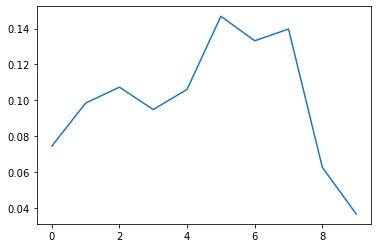

In [196]:
plt.plot(pred_mean) 
#should ideally be a flat line since we are doing binning by quantiles

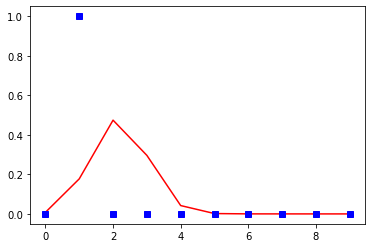

In [200]:
#Plotting single point
plt.plot(pred[20,5,20,0,:], 'r', y_true[20,5,20,0,:], 'bs')

In [204]:
#pred_inverse=discretizer.inverse_transform(tf.reshape(pred, (-1,10)))

In [386]:
#plt.hist(pred_inverse, bins=discretizer.bin_edges_[0]) 

In [ ]:
#Another method to discretize.
# import pandas as pd

# z3=z.flatten()
# z3.shape
# bins2=pd.qcut(z3, 10, labels=False,retbins=True) 
# #quantiles based method. ensures almost equal items per bin
# bins2
# bins2[0].shape, bins2[1].shape #bins, bin-edges

# from collections import Counter
# recounted=Counter(bins2[0])
# recounted

# #this is useless. we had to do onehot encoding.

#another method

# z4=bins2[0]
# z4.shape, type(z4)
# values = z4
# #print(values)
# # integer encode
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)
# #print(integer_encoded)
# # binary encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)
# # # invert first example
# # inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# # print(inverted)

# values=z4
# onehot_encoder = OneHotEncoder(sparse=False)
# values = values.reshape(len(values), 1)
# onehot_encoded = onehot_encoder.fit_transform(values)

# print(values.shape, values[6000])
# print('min:', values.min(), 'max:', values.max())

# onehot_encoded.shape, onehot_encoded[6000]

In [ ]:
#ATTEMPTING UNIFORM BINNING

In [176]:
X.shape, y.shape

((992, 32, 64, 93), (992, 32, 64, 2))

In [188]:
y.min(), y.max()

(-3.7825012, 2.6023862)

In [189]:
bins=np.linspace(-4, 4, 21)
bins

array([-4. , -3.6, -3.2, -2.8, -2.4, -2. , -1.6, -1.2, -0.8, -0.4,  0. ,
        0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ])

In [217]:
bins[0]=-np.inf; bins[-1]=np.inf

In [218]:
bins

array([-inf, -3.6, -3.2, -2.8, -2.4, -2. , -1.6, -1.2, -0.8, -0.4,  0. ,
        0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  inf])

In [219]:
import pandas as pd

In [220]:
y.reshape(-1).shape

(4063232,)

In [221]:
y.max(), y.min()

(4.7, -3.7825012)

In [222]:
y1=y

In [223]:
y1[0,0,0,0]=4.7

In [224]:
y[0,0,0,0]

4.7

In [235]:
a=pd.cut(y1.reshape(-1), bins, labels=False)

In [236]:
a

array([19,  6,  6, ...,  7,  7,  8])

In [227]:
a.shape

(4063232,)

In [228]:
a.min(), a.max()

(0, 19)

In [237]:
d=a.reshape(y.shape)
d.shape

(992, 32, 64, 2)

In [230]:
import tensorflow.keras.utils as np_utils

In [231]:
c=np_utils.to_categorical(d, num_classes=20)

In [232]:
c.max(), c.min()

(1.0, 0.0)

In [233]:
c.shape

(992, 32, 64, 2, 20)

In [234]:
c[0,0,0,0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)

In [43]:
from src.data_generator_categorical import *

In [85]:
def custom_categorical_loss(y_true, y_pred):
    #assert tf.shape(y_true)==tf.shape(y_pred)
    #assert tf.rank(y_true)==5 #[batch_size, lat, lon, 2, ]
    #assert tf.shape(y_true)[3]==2 #len(args['outpt_vars'])
    
    cce=tf.keras.losses.CategoricalCrossentropy()
    cce1=cce(y_true[:,:,:,0,:], y_pred[:,:,:,0,:])
    cce2=cce(y_true[:,:,:,1,:], y_pred[:,:,:,1,:])
    return (cce1+cce2)